In [1]:
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from pprint import pprint


import numpy as np
import pandas as pd
import rasterio
import glob
import os
import time

import math
import random

from scipy.ndimage.filters import gaussian_filter
from rasterio import features


In [2]:
data_type = 'NAIP2018'
annotation_type = 'Hand'
area = 'Nubian_square'
notes = 'Robin'

site_name = '{0}_{1}_{2}_{3}'.format(data_type, annotation_type, area, notes)

image_type = ".tif"

score_threshold = 0.3

In [9]:
# current working directory
cwd = os.getcwd()

# list images in relative path
test_data_path = '../../../data/' + site_name + '/training_data/*' + image_type
image_path_list = glob.glob(test_data_path)

# reference bboxes
annotations_path = '../../../data/' + site_name + '/training_data/*.csv'
annotations_path_list = glob.glob(annotations_path)

# list images in relative path
test_data_path = '../../../data/' + site_name + '/tif/*CLIP4' + image_type
image_path_list = glob.glob(test_data_path)
raster_path = image_path_list[0]

# find inference results (predictions)
prediction_data_path = '../../../data/' + site_name + '/predictions/'
path_df_predicted_bboxes = prediction_data_path + raster_path.split('/')[-1].split('.')[0] + '_raster_prediction.csv'


print('working directory:', cwd)
print('-------------------------------------------')
pprint('Number of images: '+ str(len(image_path_list)))
print('-------------------------------------------')
pprint(image_path_list[0:5])
print('-------------------------------------------')
print('reference_data:\n', annotations_path)
print('-------------------------------------------')
print('raster_data:\n', raster_path)
print('-------------------------------------------')
print('predictions_data:\n', path_df_predicted_bboxes)

working directory: /home/chris/Documents/GreenCityWatch/TreeTect_legacy/scripts/3_Precision_calculation
-------------------------------------------
'Number of images: 1'
-------------------------------------------
['../../../data/NAIP2018_Hand_Nubian_square_Robin/tif/m_4207148_nw_19_060_20181016_CLIP4.tif']
-------------------------------------------
reference_data:
 ../../../data/NAIP2018_Hand_Nubian_square_Robin/training_data/*.csv
-------------------------------------------
raster_data:
 ../../../data/NAIP2018_Hand_Nubian_square_Robin/tif/m_4207148_nw_19_060_20181016_CLIP4.tif
-------------------------------------------
predictions_data:
 ../../../data/NAIP2018_Hand_Nubian_square_Robin/predictions/m_4207148_nw_19_060_20181016_CLIP4_raster_prediction.csv


In [10]:
## read data into variables
df_lidr_bbox = pd.DataFrame()

df_lidar_bbox_temp = []

for annotations_path in annotations_path_list:
    df_lidar_bbox_temp = pd.read_csv(annotations_path, header = None)
    df_lidr_bbox = df_lidr_bbox.append(df_lidar_bbox_temp)
    
df_lidr_bbox.columns = ['image_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label']   


predicted_raster = pd.read_csv(path_df_predicted_bboxes, sep='\t', index_col = 0)

In [11]:
predicted_raster.head()

,xmin,ymin,xmax,ymax,score,label,image
0,674,3787,695,3808,0.766388,Tree,m_4207148_nw_19_060_20181016_CLIP4.tif
1,728,3081,756,3106,0.725837,Tree,m_4207148_nw_19_060_20181016_CLIP4.tif
2,951,3278,980,3305,0.723165,Tree,m_4207148_nw_19_060_20181016_CLIP4.tif
3,377,2167,397,2192,0.720948,Tree,m_4207148_nw_19_060_20181016_CLIP4.tif
4,70,2473,101,2497,0.718774,Tree,m_4207148_nw_19_060_20181016_CLIP4.tif


In [12]:
# read raster info 
dataset = rasterio.open(raster_path)

crs = dataset.read_crs()
image_array = dataset.read()

# get raster size in meters
raster_size_x = dataset.bounds.right - dataset.bounds.left
raster_size_y = dataset.bounds.top - dataset.bounds.bottom

# get raster resolution in meters
y_res = abs(dataset.read_transform()[1])
x_res = abs(dataset.read_transform()[5])

In [13]:
# loading model results
score_threshold = 0.2

run_all = False
sample_size = 10

use_metric_system = False

running sample of trees


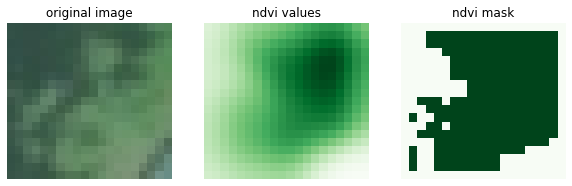

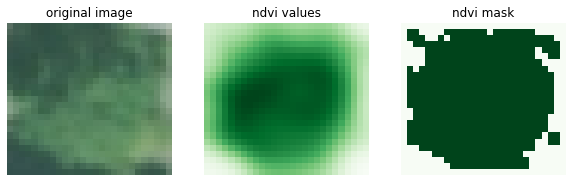

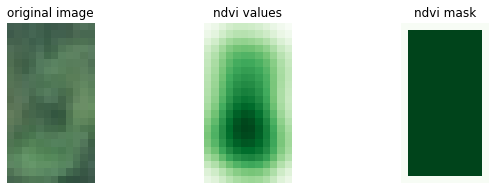

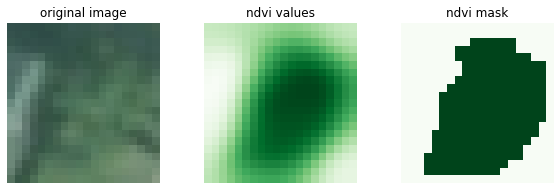

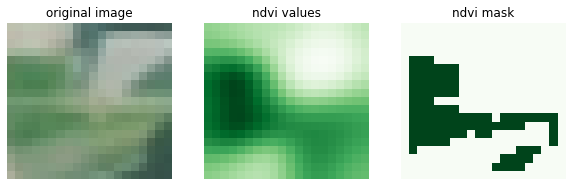

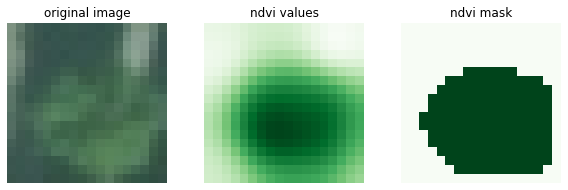

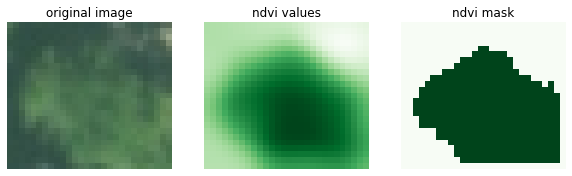

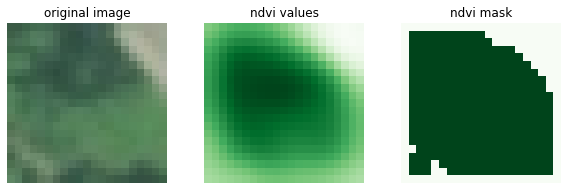

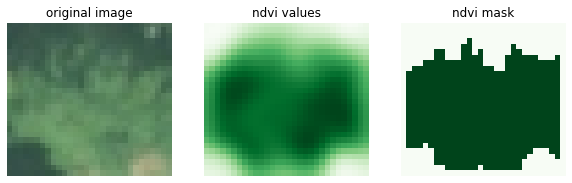

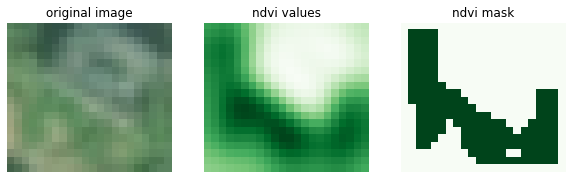

In [14]:

# convert values if metric or feet
if use_metric_system:
    m2ftconversion = 1    
else:
    m2ftconversion = 3.28084

if run_all:
    plot_individuals = False
else:
    plot_individuals = True

# create data frames to save results
# check size
predicted_raster['ns_spread'] = 0
predicted_raster['ew_spread'] = 0
predicted_raster['volume'] = 0
predicted_raster['area'] = 0

# health
predicted_raster['ndvi_avg'] = 0
predicted_raster['evi_avg'] = 0
predicted_raster['savi_avg'] = 0




predicted_raster.iloc[1,:]

if run_all:
    run_nr = range(len(predicted_raster))
else:
    run_nr = random.sample(range(len(predicted_raster)), sample_size)
    print('running sample of trees')


for i in tqdm(run_nr):
    
    # get row
    row = predicted_raster.loc[i,:]
   
    # slice array to tree
    crown_image = image_array[:, int(row['ymin']):int(row['ymax']), int(row['xmin']):int(row['xmax'])]
    
    # get bands
    RED = crown_image[0,:,:].astype(np.float32)
    GREEN = crown_image[1,:,:].astype(np.float32)
    BLUE = crown_image[2,:,:].astype(np.float32)
    NIR = crown_image[3,:,:].astype(np.float32)
    
    ## vegetation indices    
    # NDVI
    ndvi = (NIR - RED) / (NIR + RED)
    ndvi_avg = np.average(ndvi)
    predicted_raster.loc[i,('ndvi_avg')] = ndvi_avg
    # EVI
    G = 2.5; L = 2.4; C = 1
    evi = G*((NIR-RED)/(L+NIR+C*RED))
    evi_avg = np.average(evi)
    predicted_raster.loc[i,('evi_avg')] = evi_avg
    # SAVI
    L = 0.5
    savi = ((NIR - RED) / (RED + NIR + L)) * (1+L)
    savi_avg = np.average(savi)
    predicted_raster.loc[i,('savi_avg')] = savi_avg
    
    # calculate spread of crown (no mask yet)
    north_south_spread = ((row['ymax'] - row['ymin']) * y_res) * m2ftconversion
    east_west_spread   = ((row['xmax'] - row['xmin']) * x_res) * m2ftconversion
    predicted_raster.loc[i,'ns_spread'] = north_south_spread
    predicted_raster.loc[i,'ew_spread'] = east_west_spread
    # calculate area
    area = north_south_spread * east_west_spread
    predicted_raster.loc[i,'area'] = area
    
    # calculate volume 
    volume = 4/3 * math.pi * north_south_spread * east_west_spread * (((north_south_spread+east_west_spread)/2)/2)
    predicted_raster.loc[i,'volume'] = volume
    
    # remove edge pixels
    ndvi[0,:]  = 0
    ndvi[-1,:] = 0
    ndvi[:,0]  = 0
    ndvi[:,-1] = 0
    
    # apply mask
    ndvi_mask = ndvi > 0.15
    
    # appy gaussian
    ndvi = gaussian_filter(ndvi, sigma=2)    
    
    if plot_individuals:
        
        plot_image = np.rot90(np.flipud(crown_image[0:3,:,:].T), k = 3)

        plt.figure(figsize = (10,10))
        # ----
        plt.subplot(3,3,3)
        plt.imshow(ndvi_mask, cmap = 'Greens')  
        plt.title('ndvi mask')
        plt.axis('off')
        # ----
        plt.subplot(3,3,2)
        plt.imshow(ndvi, cmap = 'Greens') 
        plt.title('ndvi values')
        plt.axis('off')
        # ----
        plt.subplot(3,3,1)
        plt.imshow(plot_image)
        plt.title('original image')
        plt.axis('off')





        plt.show()

# Calculate metrics

Text(0.5, 1.0, 'Spread distance histogram')

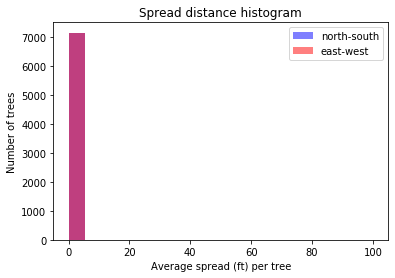

In [55]:
# plt.hist(predicted_raster.ew_spread, color='green')

bins = np.linspace(0, 100, 20)
plt.hist(predicted_raster.ns_spread, bins, alpha=0.5, label='north-south', color = 'blue')
plt.hist(predicted_raster.ew_spread, bins, alpha=0.5, label='east-west', color = 'red')

plt.legend()
plt.xlabel('Average spread (ft) per tree')
plt.ylabel('Number of trees')
plt.title('Spread distance histogram')

Text(0.5, 1.0, 'NDVI average histogram')

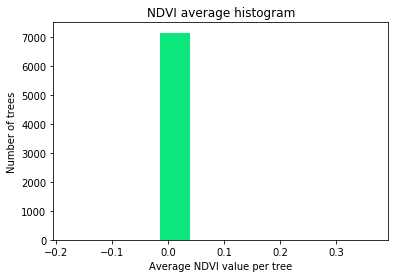

In [56]:
plt.hist(predicted_raster.ndvi_avg, color='#0ce67d')
plt.xlabel('Average NDVI value per tree')
plt.ylabel('Number of trees')
plt.title('NDVI average histogram')

In [57]:
# recalculate coordinates 
predicted_raster['xmin'] = (predicted_raster['xmin'] * x_res + (dataset.bounds.left)) 
predicted_raster['xmax'] = (predicted_raster['xmax'] * x_res + (dataset.bounds.left)) 

predicted_raster['ymax'] = (raster_size_y - ((predicted_raster['ymax'] * y_res))) + dataset.bounds.bottom
predicted_raster['ymin'] = (raster_size_y - ((predicted_raster['ymin'] * y_res))) + dataset.bounds.bottom

# write results to shapefile 

In [37]:
# write results to shapefile 

from shapely.geometry import mapping, Polygon, box
import fiona

prediction_data_path = '../../data/' + site_name + '/predictions/'
path_shp_predicted_bboxes = prediction_data_path + raster_path.split('/')[-1].split('.')[0] + '_predictions.shp'

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'score': 'float' , 
                   'ns_spread' : 'float',
                   'ew_spread' : 'float',
                   'volume' : 'float',
                   'ndvi_avg' : 'float',
                   'savi_avg' : 'float',
                   'evi_avg': 'float'},
}

# Write a new Shapefile
with fiona.open(path_shp_predicted_bboxes,'w',  
                crs=crs,
                driver = 'ESRI Shapefile', 
                schema = schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    for index, row in predicted_raster.iterrows():
        ## Its x-y bounding box is a (minx, miny, maxx, maxy) tuple.
        poly = box(row['xmin'], row['ymax'], row['xmax'], row['ymin'])
        c.write({
            'geometry': mapping(poly),
            'properties': {'score': row['score'], 
                           'ns_spread' : row['ns_spread'],
                           'ew_spread' : row['ew_spread'],
                           'volume' : row['volume'],
                           'ndvi_avg': row['ndvi_avg'],
                           'savi_avg': row['savi_avg'],
                           'evi_avg' : row['evi_avg']},
        })